# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from helpers.plotting import *
from helpers.physics_functions import *

plt.style.use("../science.mplstyle")



In [29]:
project_id = "lowmass"
path_to_compiled_data = f"/pscratch/sd/r/rmastand/dimuonAD/compiled_data/{project_id}"

    
if project_id == "SUSY":
    codes_list = ["BSM_HAA", "SM_SIM"]
    sim_id = "SM_SIM"
    signal_id = "BSM_HAA"
    
elif project_id == "etaj":
    codes_list = ["DATA_jet"]
    sim_id = "DATA_jet"
    signal_id = "DATA_jet"
    
    
elif project_id == "lowmass":
    codes_list = ["DATA_nojet"]
    sim_id = "DATA_nojet"
    signal_id = "DATA_nojet"

    
uncut_data = {}
for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        uncut_data[code] = pickle.load(ifile)
    
    print(code, uncut_data[code][list(uncut_data[code].keys())[0]].shape)

DATA_nojet (21803678,)


## Visualize the data

['mu0_iso03', 'mu1_iso03', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mumu_deltaR', 'mumu_deltapT']


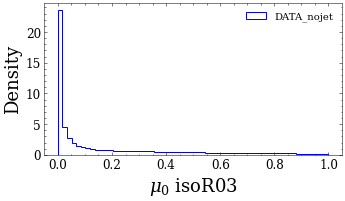

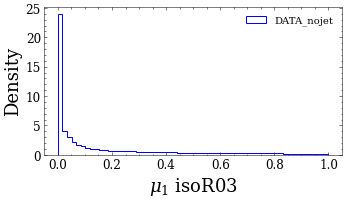

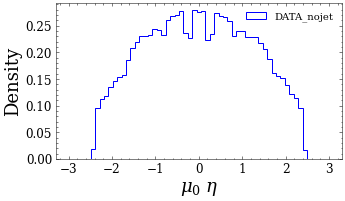

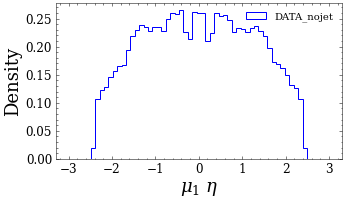

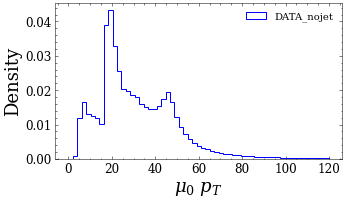

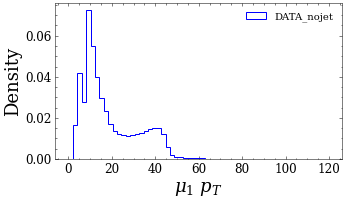

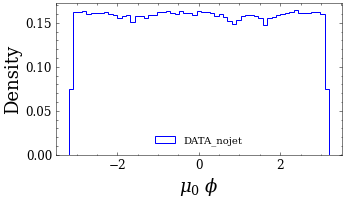

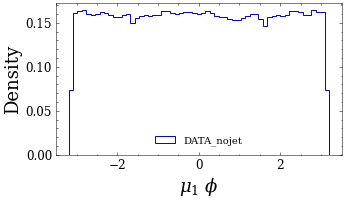

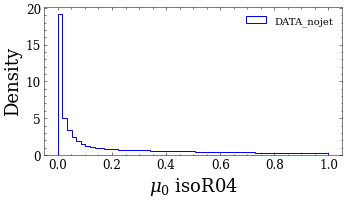

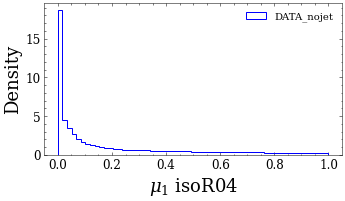

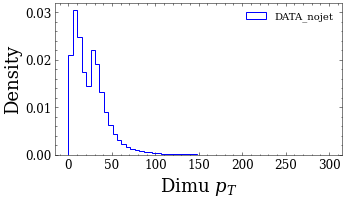

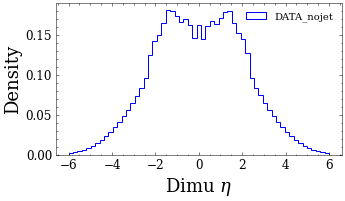

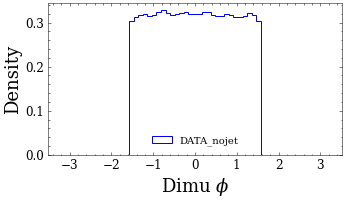

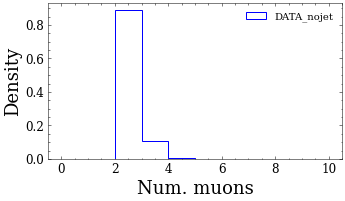

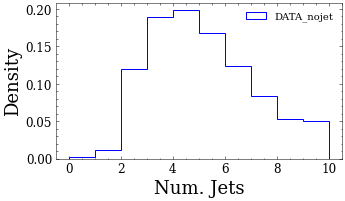

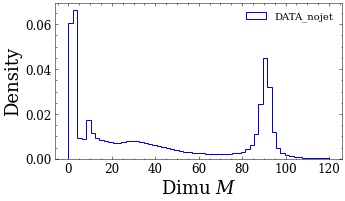

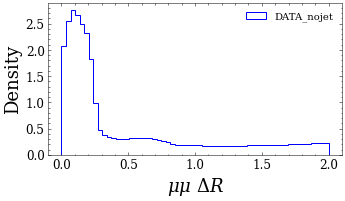

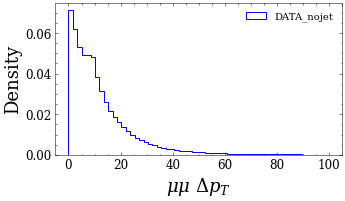

In [30]:
feature_set = list(uncut_data[codes_list[0]].keys())
print(feature_set)

hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype, nice_labels=True)
    


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [77]:
particle_type = "eta"

if particle_type == "eta":
    band_bounds = {"SBL": [0.3, 0.527],
                   "SR": [0.527, 0.567],
                   "SBH": [0.567, 0.72], 
                           }
    N_test = 32000
    left_bound, right_bound = 0.3, 0.72
    SR_left, SR_right = 0.527, 0.567
    #random_seed = 1
    random_seed = 2


elif particle_type == "upsilon":
    band_bounds = {"SBL": [8, 9],
                   "SR": [9, 10.6],
                   "SBH": [10.6, 15], 
                           }
    N_test = 32000
    left_bound, right_bound = 8,15
    SR_left, SR_right = 9, 10.6
    random_seed = 3 # 25 bad
    
    
elif particle_type == "none":
    band_bounds = {"SBL": [14, 17.5],
                   "SR": [17.5, 19.5],
                   "SBH": [19.5, 23], 
                           }
    N_test = 100000

plot_bins_SR = np.linspace(SR_left, SR_right, 6)
width = plot_bins_SR[1] - plot_bins_SR[0]

In [78]:


cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    if particle_type == "eta" or particle_type == "none":
        pass_indices = (uncut_data[code]["mu0_iso04"] > -.5) & (uncut_data[code]["mu1_iso04"] > -.5)
        
    elif particle_type == "upsilon":
        pass_indices = (uncut_data[code]["mu0_iso04"] > 0.5) & (uncut_data[code]["mu1_iso04"] > 0.5)
        
        
    cut_data[code] = {}
    for feat in feature_set:
        cut_data[code][feat] = uncut_data[code][feat][pass_indices]
    
    print(f"{code} has shape {cut_data[code][feat].shape} after cuts")
    

DATA_nojet has shape (21803678,) after cuts


Check how local cuts affect the starting significance

In [79]:
"""
p0  = [5000, -20000, 30000, -10000]

plt.figure(figsize = (7,5))

bins = np.arange(left_bound, right_bound, width)
x = np.linspace(left_bound, right_bound, 100)

masses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= left_bound) & (cut_data[code]["dimu_mass"] <= right_bound)]

# no extra cut

loc_data = masses_with_bounds
print(loc_data.shape)
popt_0, _, _ = curve_fit_m_inv(loc_data, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, p0)
#plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, popt_0)
plt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = True, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")

np.random.shuffle(masses_with_bounds)
loc_data = masses_with_bounds[:30000]

popt_0, _, _ = curve_fit_m_inv(loc_data, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, p0)
plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, popt_0)
plt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))
plt.show()
 
    
#hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype)
"""

'\np0  = [5000, -20000, 30000, -10000]\n\nplt.figure(figsize = (7,5))\n\nbins = np.arange(left_bound, right_bound, width)\nx = np.linspace(left_bound, right_bound, 100)\n\nmasses_with_bounds = cut_data[code]["dimu_mass"][(cut_data[code]["dimu_mass"] >= left_bound) & (cut_data[code]["dimu_mass"] <= right_bound)]\n\n# no extra cut\n\nloc_data = masses_with_bounds\nprint(loc_data.shape)\npopt_0, _, _ = curve_fit_m_inv(loc_data, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, p0)\n#plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")\nnum_S_expected_in_SR, num_B_expected_in_SR = calc_significance(loc_data, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, popt_0)\nplt.hist(loc_data, bins = bins, lw = 2, histtype = "step", density = True, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")\n\nnp.random.shuffle(masses_with_bounds)\nloc_data = masses_wi

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

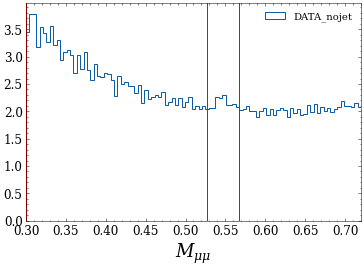

In [80]:
plt.figure()

for code in codes_list:
    plt.hist(cut_data[code]["dimu_mass"], bins = np.linspace(band_bounds["SBL"][0], band_bounds["SBH"][1], 100), histtype = "step", density = "True", label = code)

plt.legend()
plt.axvline(band_bounds["SBL"][0], color= "red")
#plt.axvline(band_bounds["IBL"][0], color= "red")
plt.axvline(band_bounds["SR"][0], color= "red")
#plt.axvline(band_bounds["IBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][1], color= "red")

plt.xlabel("$M_{\mu\mu}$")

plt.xlim(band_bounds["SBL"][0], band_bounds["SBH"][1])
#plt.yscale("log")
plt.show()

In [81]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
#IBL_data_preprocc = {} # innerband low
#IBH_data_preprocc = {} # innerband high

bands = ["SBL", "SR", "SBH"]
N_total_events = 0

sizes_dict = {}

preproc_dicts = {b:{} for b in bands}


for code in codes_list:
    for b in bands:

        loc_pass_indices = (cut_data[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data[code]["dimu_mass"] < band_bounds[b][1])
        
        preproc_dicts[b][code] = {}

        for feat in feature_set:
            preproc_dicts[b][code][feat] = cut_data[code][feat][loc_pass_indices]
            
        sizes_dict[b] = preproc_dicts[b][code][feat].shape[0]

        print(f"{code} {b} has shape {preproc_dicts[b][code][feat].shape}")
        N_total_events += preproc_dicts[b][code][feat].shape[0]
        
    print()
   
    
    
print(f"Total events: {N_total_events}")
    

DATA_nojet SBL has shape (334327,)
DATA_nojet SR has shape (47627,)
DATA_nojet SBH has shape (172355,)

Total events: 554309


In [82]:
print(sizes_dict)

{'SBL': 334327, 'SR': 47627, 'SBH': 172355}


## Preprocessing

Standard scaling is fine

In [83]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

proccessed_data_dict = {b:{"s_inj_data":{}} for b in bands}


    

for feat in feature_set: # also could scale everythign together - same results, but maybe more efficient
    
    SB_all = np.hstack((preproc_dicts["SBL"][sim_id][feat], preproc_dicts["SBH"][sim_id][feat])).reshape(-1, 1)
    loc_feat_scaler = StandardScaler()
    loc_feat_scaler = loc_feat_scaler.fit(SB_all)
    
    if feat == "dimu_mass":
    
        with open(f"processed_data/mass_scaler_{particle_type}", "wb") as ofile:
            pickle.dump(loc_feat_scaler, ofile)
            mass_scaler = loc_feat_scaler

    
    for b in bands:
        proccessed_data_dict[b]["s_inj_data"][feat] = loc_feat_scaler.transform(preproc_dicts[b][sim_id][feat].reshape(-1, 1))
        if ("pt" in feat) or ("iso" in feat) or ("jet_mass" in feat) or ("deltapT" in feat):
            proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat]-10)/4
        if particle_type == "eta":
            if ("mumu_deltaR" in feat):
                proccessed_data_dict[b]["s_inj_data"][feat] = (proccessed_data_dict[b]["s_inj_data"][feat]-2)/2

            



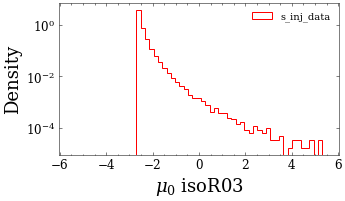

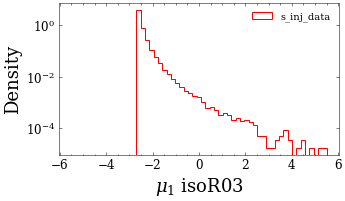

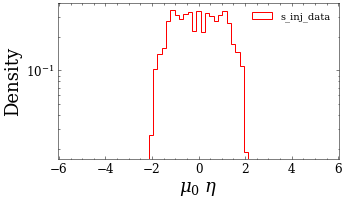

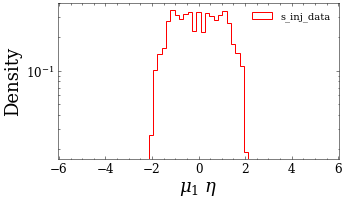

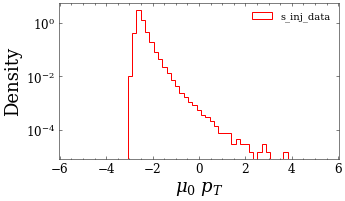

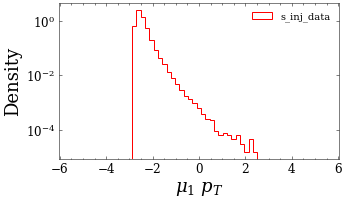

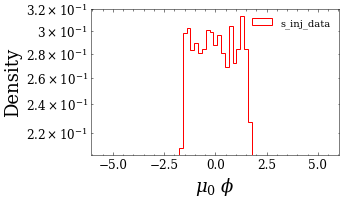

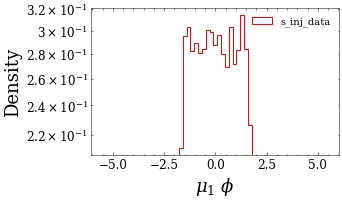

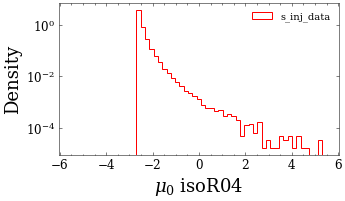

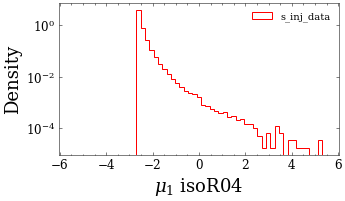

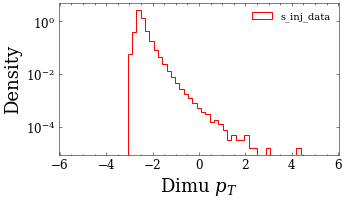

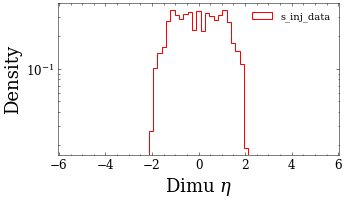

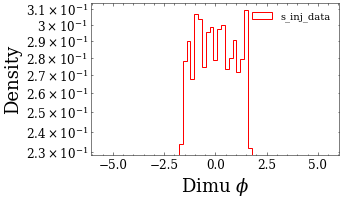

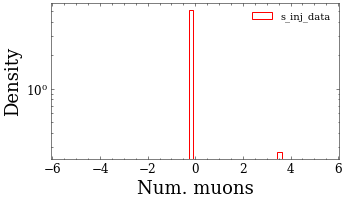

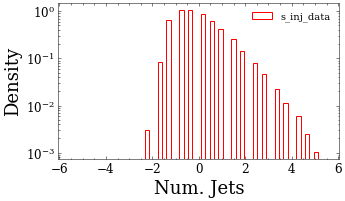

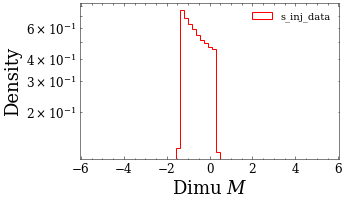

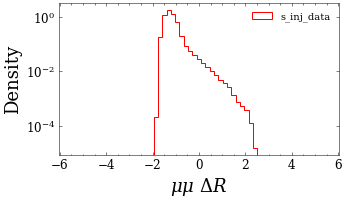

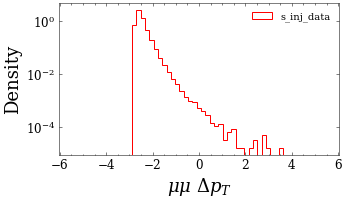

In [84]:
hist_all_features(["s_inj_data"], proccessed_data_dict["SBL"], feature_set, kwargs_dict_dtype, 
                  scaled_features = True, plot_bound = 5.5, yscale_log = True, nice_labels = True)


In [133]:
# specify a percentage of events to set aside for the test set


train_data_dict = {b:{"s_inj_data":{}} for b in bands}
test_data_dict = {b:{"s_inj_data":{}} for b in bands}

x = 0

for b in bands:
    
    # get indices to select
    loc_num_test_events = int((N_test/N_total_events)*sizes_dict[b])
    x += loc_num_test_events
    
    np.random.seed(19)
    test_set_inds = np.random.choice(range(sizes_dict[b]), size = loc_num_test_events, replace = False)
    train_set_inds = np.setdiff1d(list(range(sizes_dict[b])),test_set_inds)
        
    for feat in feature_set:
        
        train_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds]
        test_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds]


test_set_size = test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size = train_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]

print(f"{test_set_size} test events (target: {N_test}). {train_set_size} train events")      




    


31998 test events (target: 32000). 522311 train events


In [134]:
## trial_train_set = mass_scaler.inverse_transform(np.concatenate((train_data_dict["SBL"]["s_inj_data"]["dimu_mass"], train_data_dict["SBH"]["s_inj_data"]["dimu_mass"], train_data_dict["SR"]["s_inj_data"]["dimu_mass"])))
trial_test_set = mass_scaler.inverse_transform(np.concatenate((test_data_dict["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict["SR"]["s_inj_data"]["dimu_mass"])))


Check starting significances

(31998, 1)
142.28197222646304 2606.718027773537


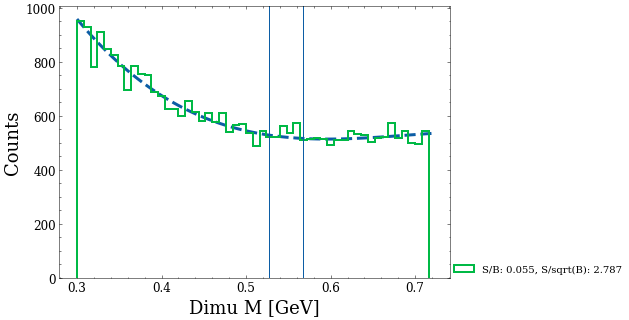

In [135]:
p0  = [5000, -20000, 30000, -10000]

plt.figure(figsize = (7,5))

bins = np.arange(left_bound, right_bound, width)
x = np.linspace(left_bound, right_bound, 100)



# no extra cut

"""
print(trial_train_set.shape)
popt_0, _, _ = curve_fit_m_inv(trial_train_set, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, p0)
plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(trial_train_set, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, popt_0)
plt.hist(trial_train_set, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")
"""

print(trial_test_set.shape)
popt_0, _, _, _, _ = curve_fit_m_inv(trial_test_set, bkg_fit_cubic, left_bound, right_bound, SR_left, SR_right, width, p0)
plt.plot(x, bkg_fit_cubic(x, *popt_0), lw = 3, linestyle = "dashed")
num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(trial_test_set, bkg_fit_cubic, plot_bins_SR, SR_left, SR_right, popt_0)

print(num_S_expected_in_SR, num_B_expected_in_SR)

plt.hist(trial_test_set, bins = bins, lw = 2, histtype = "step", density = False, label = f"S/B: {round(num_S_expected_in_SR/num_B_expected_in_SR,3)}, S/sqrt(B): {round(num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR),3)}")

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

plt.axvline(SR_left)
plt.axvline(SR_right)

plt.show()
 
    

In [136]:
with open(f"processed_data/{project_id}_{particle_type}_nojet_train_band_data", "wb") as ofile:
    pickle.dump(train_data_dict, ofile)
        
        
with open(f"processed_data/{project_id}_{particle_type}_nojet_test_band_data", "wb") as ofile:
    pickle.dump(test_data_dict, ofile)